# Testing single image inference

This notebook is aimed at prototyping the framework for running inference on a single image and confirming output.

In [1]:
import os.path as op
import json
import requests
import tempfile
import logging

from tqdm import tqdm
import tensorflow as tf
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.collections import PatchCollection
from matplotlib import patches,  lines
from matplotlib.patches import Polygon
from skimage.transform import resize, rescale
from skimage.measure import find_contours
from osgeo import ogr
import rasterio

from divdet.inference.inference_runner import arr_to_b64, pred_generator
from divdet.inference.utils_inference import (
    iter_grouper, get_slice_bounds, yield_windowed_reads_numpy,
    windowed_reads_numpy, calculate_region_grad, calculate_shape_props,
    poly_non_max_suppression, convert_mask_to_polygon)


image_fpath = '/Users/wronk/Builds/divdet/test/fixtures/img2.png'
geotiff_fpath = '/Users/wronk/Builds/divdet/test/fixtures/test_geotiff.tif'

endpoint = 'http://localhost:8501/v1/models/divdet-inference:predict'

In [2]:
image_pil = Image.open(image_fpath).convert('RGB')
image_arr = np.array(image_pil)

instances = []  # List that will hold b64 images to be sent to endpoint
b64_image = arr_to_b64(image_arr)

#XXX KF Serving example here:
#    https://github.com/kubeflow/kfserving/blob/master/docs/samples/tensorflow/input.json
instances.append({'b64': b64_image})

################
# Run prediction

payload = json.dumps({"inputs": {"input_tensor": instances}})  # TF "col" format

resp = requests.post(endpoint, data=payload)
preds = json.loads(resp.content)
preds = preds['outputs']
print(f'preds.keys():\n{preds.keys()}')

preds.keys():
dict_keys(['detection_multiclass_scores', 'anchors', 'num_proposals', 'image_shape', 'detection_boxes', 'rpn_objectness_predictions_with_background', 'detection_scores', 'detection_masks', 'rpn_features_to_crop', 'detection_anchor_indices', 'refined_box_encodings', 'mask_predictions', 'final_anchors', 'detection_classes', 'num_detections', 'rpn_box_predictor_features', 'class_predictions_with_background', 'proposal_boxes', 'raw_detection_boxes', 'rpn_box_encodings', 'box_classifier_features', 'raw_detection_scores', 'proposal_boxes_normalized'])


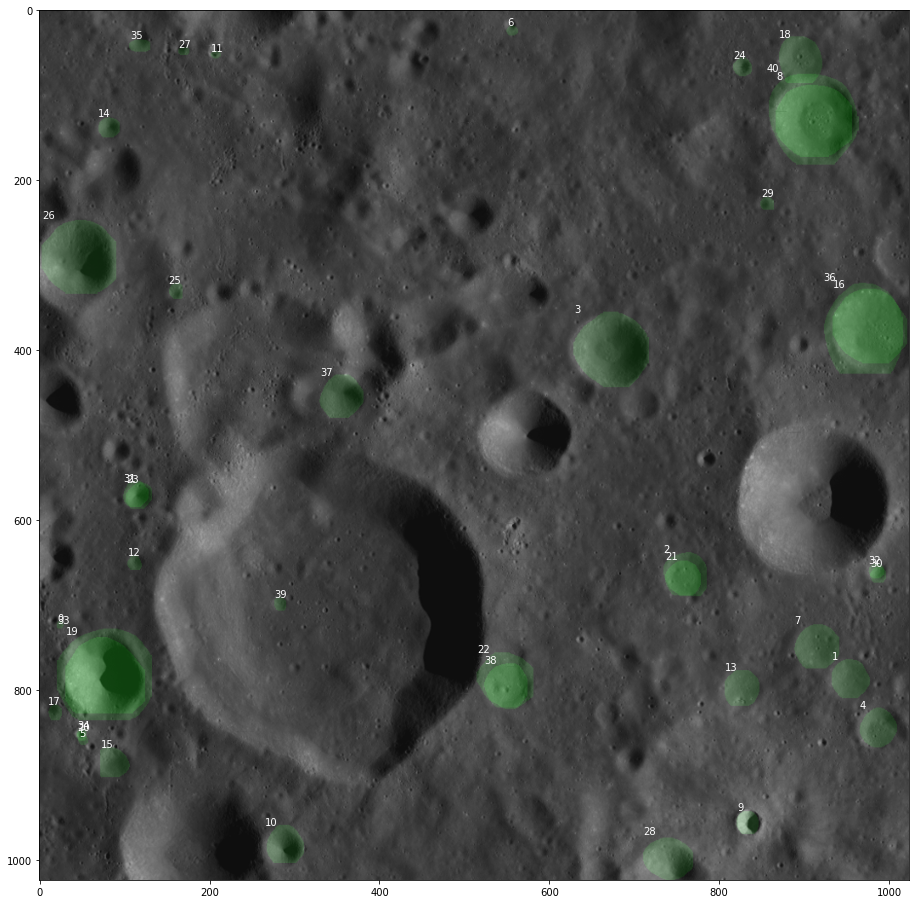

In [3]:
fig, ax = plt.subplots(figsize=(16, 16))
ax.imshow(image_arr)

individual_masks = []
mask_collection = np.zeros_like(image_arr)

for ci, (score, box, mask) in enumerate(zip(preds['detection_scores'][0], 
                                            preds['proposal_boxes'][0], 
                                            preds['detection_masks'][0])):
    if score < 0.5: 
        continue
        
    mask_arr_orig = np.array(mask)
    
    #In TF coords, x increases going right; y increases going down
    tf_ymin, tf_xmin, tf_ymax, tf_xmax = box
    tf_ymin = int(np.round(tf_ymin))
    tf_ymax = int(np.round(tf_ymax))
    tf_xmin = int(np.round(tf_xmin))
    tf_xmax = int(np.round(tf_xmax))
    width = tf_xmax - tf_xmin
    height = tf_ymax - tf_ymin
    
    # Add mask
    mask_arr = resize(mask_arr_orig, (height, width), mode='edge', anti_aliasing=True)
    individual_masks.append(mask_arr)

    # Add with some transparency so we can see overlapping craters
    mask_collection[tf_ymin:tf_ymax, tf_xmin:tf_xmax, 1] += (85 * (mask_arr[:, :] > 0.5)).astype(np.uint8)
    
    ax.text(tf_xmin, tf_ymin, str(ci), color='white')

ax.imshow(mask_collection, alpha=0.3)


## Plot WKT polygon

NameError: name 'individual_masks' is not defined

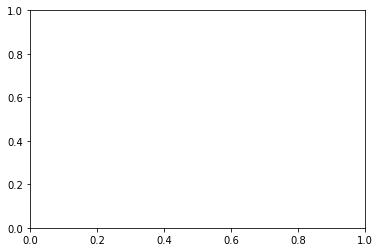

In [5]:
# Plot GDAL polygon
fig, ax = plt.subplots()

patches = []
polys = [convert_mask_to_polygon(mask, simplify_tol=1) for mask in individual_masks]
big_ind = np.argmax([poly.Area() for poly in polys])
print(f'Largest ind: {10}')

#poly = convert_mask_to_polygon(individual_masks[big_ind])
poly = polys[big_ind]
pts = np.array([pt[0:2] for pt in poly.GetGeometryRef(0).GetPoints()])
mpl_polygon = Polygon(pts, color='g')
patches.append(mpl_polygon)

p = PatchCollection(patches, alpha=0.4)
ax.add_collection(p)
ax.set_xlim(-3, np.max(pts[:, 0]) + 3)
ax.set_ylim(-3, np.max(pts[:, 1]) + 3)
ax.set_title(f'Polygon of {len(pts)} points.')
ax.set_aspect('equal')
plt.show()

In [2]:
def geospatial_polygon_transform(poly, transform):
    """Convert a polygon from pixel coords to geospatial coords"""
        
    # Convert predicted mask to polygon
    gdal_ring = ogr.Geometry(ogr.wkbLinearRing)
    
    # Get single geometry from the poly object
    geom = poly.GetGeometryRef(0)
    for pi in range(geom.GetPointCount()):
        pt = transform * geom.GetPoint(pi)[:2]  # Only take first 2 coords in case 3 exist
        gdal_ring.AddPoint(*pt)
        
    # Create polygon
    gdal_poly = ogr.Geometry(ogr.wkbPolygon)
    gdal_poly.AddGeometry(gdal_ring)

    return gdal_poly

## Process geotiff image

In [4]:
msg_dict = {}
msg_dict['scales'] = [0.5]
msg_dict['window_size'] = 1024
msg_dict['min_window_overlap'] = 500
#msg_dict['sub_solar_azimuth'] = float(msg_dict['sub_solar_azimuth'])
msg_dict['batch_size'] = 2
msg_dict['prediction_endpoint'] = endpoint

# Use temp directory so everything is deleted after image processing completes
with tempfile.TemporaryDirectory() as tmp_dir:
    ###########################################################
    # Slice image appropriately and pass to prediction endpoint
    ###########################################################
    preds = {'detection_scores': [], 'detection_masks': [], 'proposal_boxes': [], 
             'proposal_boxes_normalized': [], 'polygons': [], 'resized_masks': []}
    slices = []
    with rasterio.open(geotiff_fpath) as dataset:
        image = dataset.read(1)  # Read data from first band
        if image.dtype == np.uint16:
            image = (image / 65535. * 255).astype(np.uint8)

        for scale in msg_dict['scales']:
            logging.info('Processing at scale %s', scale)

            # Rescale image, round, and convert back to orig datatype

            scaled_image = rescale(image, scale, mode='edge', preserve_range=True, 
                                   anti_aliasing=True).round().astype(image.dtype)

            # Calculate slice bounds and create generator
            slice_bounds = get_slice_bounds(
                scaled_image.shape,
                slice_size=(msg_dict['window_size'], msg_dict['window_size']),
                min_window_overlap=(msg_dict['min_window_overlap'], msg_dict['min_window_overlap']))

            logging.info('Created %s slices.', (len(slice_bounds)))
            slice_batch = windowed_reads_numpy(scaled_image, slice_bounds)

            # Generate predictions predictions
            pred_gen = pred_generator(slice_batch,
                                      msg_dict['prediction_endpoint'])
            pred_batch = list(pred_gen)
            
            
            # Convert predictions to polygon in orig image coordinate frame
            for pred_set, slice_set in zip(pred_batch, slice_bounds):
                x_offset_img = np.int(slice_set[0] / scale)
                y_offset_img = np.int(slice_set[1] / scale)
                
                pred_set['polygons'] = []
                pred_set['resized_masks'] = []

                for mask, box in zip(pred_set['detection_masks'], pred_set['proposal_boxes']):

                    width = np.int((box[3] - box[1]) / scale)
                    height = np.int((box[2] - box[0]) / scale)
                    
                    x_offset_box = box[1] / scale
                    y_offset_box = box[0] / scale
                    x_offset = x_offset_img + x_offset_box
                    y_offset = y_offset_img + y_offset_box

                    mask_arr = resize(np.array(mask), (height, width), mode='edge', 
                                      anti_aliasing=True) > 0.5 # Must be binary
                    pred_set['resized_masks'].append(mask_arr.astype(np.int))

                    mask_poly = convert_mask_to_polygon(mask_arr, (x_offset, y_offset))
                    pred_set['polygons'].append(mask_poly)  # polygon in whole-image pixel coordinates
                                    
                # XXX: could add poly non-max suppression here?

                for key in ['detection_scores', 'detection_masks', 'proposal_boxes', 'proposal_boxes_normalized', 'polygons', 'resized_masks']:
                    preds[key].extend(pred_set[key])
                
            #preds.extend(pred_batch)
            #XXX Needed?
            #slices.extend(list(slice_batch))
            logging.info(f'Finished processing at scale {scale}')

        ###########################
        # Run non-max suppression to remove duplicates within multiple scales of one image

        # Non-max suppression for bounding boxes only
        #selected_inds = tf.image.non_max_suppression(boxes, scores,
        #                                             max_output_size=len(preds))

        # Run non-max suppression that uses crater polygon mask
        selected_inds = poly_non_max_suppression(preds['polygons'], preds['detection_scores'])
        
        # Select data from TF Serving column format 
        for key in ['detection_scores', 'detection_masks', 'proposal_boxes', 'proposal_boxes_normalized', 'resized_masks']:
            preds[key] = [preds[key][ind] for ind in selected_inds]
        
        # Convert polygons from pixel coords to geospatial coords
        preds['polygons'] = [geospatial_polygon_transform(preds['polygons'][ind], dataset.transform)
                             for ind in selected_inds]
        
        # Select data from TF Serving row format 
        #preds = [preds[ind] for ind in selected_inds]
        #slices = [slices[ind] for ind in selected_inds]
        
        # Convert to geospatial coords

    ###########################
    # Loop over preds, determine properties, and store
    preds['shape_props'] = []
    for mask in preds['resized_masks']:

        # Resize mask to original prediction bbox dimensions

        # TODO: will need to bring along original image for gradient calcs
        #grad_h, grad_v = calculate_region_grad(mask.astype(np.bool))
        shape_props = calculate_shape_props(mask)
        preds['shape_props'].append(shape_props)
        

100%|██████████| 4/4 [07:32<00:00, 113.25s/it]


> <ipython-input-4-1abb4eb93658>(74)<module>()
     73 
---> 74                 for key in ['detection_scores', 'detection_masks', 'proposal_boxes', 'proposal_boxes_normalized', 'polygons', 'resized_masks']:
     75                     preds[key].extend(pred_set[key])

ipdb> x_offset_box
461.720672
ipdb> box[0]
412.995148
ipdb> box[1]
230.860336
ipdb> box
[412.995148, 230.860336, 455.632355, 273.528809]
ipdb> x_offset
461
ipdb> y_offset
825
ipdb> c
> <ipython-input-4-1abb4eb93658>(70)<module>()
     69 
---> 70                 import ipdb; ipdb.set_trace()
     71 

ipdb> c
> <ipython-input-4-1abb4eb93658>(74)<module>()
     73 
---> 74                 for key in ['detection_scores', 'detection_masks', 'proposal_boxes', 'proposal_boxes_normalized', 'polygons', 'resized_masks']:
     75                     preds[key].extend(pred_set[key])

ipdb> c
> <ipython-input-4-1abb4eb93658>(70)<module>()
     69 
---> 70                 import ipdb; ipdb.set_trace()
     71 

ipdb> c


In [5]:
# Create the output Driver
outDriver = ogr.GetDriverByName('GeoJSON')
# Create the output GeoJSON
outDataSource = outDriver.CreateDataSource('test.geojson')
outLayer = outDataSource.CreateLayer('test.geojson', geom_type=ogr.wkbMultiPolygon)

# Get the output Layer's Feature Definition
featureDefn = outLayer.GetLayerDefn()
# create a new feature
outFeature = ogr.Feature(featureDefn)

# Set new geometry
multipolygon = ogr.Geometry(ogr.wkbMultiPolygon)
for pol in preds['polygons']:
    multipolygon.AddGeometry(pol)

outFeature.SetGeometry(multipolygon)

# Add new feature to output Layer
outLayer.CreateFeature(outFeature)

# dereference the feature
outFeature = None
# Save and close DataSources
outDataSource = None

POLYGON ((9868477.25864 -1486669.97836 0,9868405.89112 -1486669.97836 0,9868352.36548 -1486596.062 0,9868352.36548 -1486550.18288 0,9868367.65852 -1486514.49912 0,9868416.08648 -1486476.26652 0,9868461.9656 -1486476.26652 0,9868502.74704 -1486491.55956 0,9868525.6866 -1486514.49912 0,9868551.175 -1486570.5736 0,9868551.175 -1486590.96432 0,9868535.88196 -1486626.64808 0,9868477.25864 -1486669.97836 0))
POLYGON ((9870552.0144 -1487796.56564 0,9870312.42344 -1487796.56564 0,9870197.72564 -1487661.47712 0,9870197.72564 -1487432.08152 0,9870207.921 -1487426.98384 0,9870248.70244 -1487350.51864 0,9870297.1304 -1487307.18836 0,9870475.5492 -1487271.5046 0,9870552.0144 -1487276.60228 0,9870592.79584 -1487296.993 0,9870641.2238 -1487335.2256 0,9870722.78668 -1487467.76528 0,9870743.1774 -1487513.6444 0,9870743.1774 -1487579.91424 0,9870717.689 -1487641.0864 0,9870659.06568 -1487720.10044 0,9870577.5028 -1487771.07724 0,9870552.0144 -1487796.56564 0))
POLYGON ((9862742.36864 -1488647.8782 0,986

In [11]:
pwd

'/Users/wronk/Builds/divdet/divdet/inference'